## Prerequisites

This project uses the publicly available [Diverse Dermatology Images (DDI) dataset](https://aimi.stanford.edu/datasets/ddi-diverse-dermatology-images) curated by Stanford University. The DDI dataset contains pathologically confirmed dermatological images representing diverse skin tones.

### Dataset Requirements
- The complete DDI dataset must be downloaded from the official Stanford repository
- Images and metadata must be stored in the `data` folder in your project root directory
- Expected structure:
  - `data/images/` - Contains all dermatological images
  - `data/ddi_metadata.csv` - Contains metadata and ground truth labels

### Environment Setup
Install the required packages from `requirements.txt` file.

### Notebook Structure

This notebook follows a structured workflow:
- Loading required libraries
- Defining constants
- Loading and exploring metadata
- Analysing class distribution
- Converting labels to numeric format
- Storing processed data for model training

## Libraries

In [1]:
# Standard library imports
import os
from pathlib import Path

# Third-party imports
import pandas as pd
import matplotlib.pyplot as plt

## Constants

In [2]:
random_state = 42

# Data paths
root_path = Path.cwd().parent
data_path = root_path / 'data'
image_path = data_path / 'raw_dataset' / 'images'
metadata_path = data_path / 'raw_dataset' / 'ddi_metadata.csv'

## Load Metadata

In [3]:
# Load metadata
metadata = pd.read_csv(metadata_path)
metadata

,Unnamed: 0,DDI_ID,DDI_file,skin_tone,malignant,disease
0,0,1,000001.png,56,True,melanoma-in-situ
1,1,2,000002.png,56,True,melanoma-in-situ
2,2,3,000003.png,56,True,mycosis-fungoides
3,3,4,000004.png,56,True,squamous-cell-carcinoma-in-situ
4,4,5,000005.png,12,True,basal-cell-carcinoma
...,...,...,...,...,...,...
651,651,652,000652.png,34,False,pyogenic-granuloma
652,652,653,000653.png,34,False,melanocytic-nevi
653,653,654,000654.png,34,False,acral-melanotic-macule
654,654,655,000655.png,34,True,squamous-cell-carcinoma


<Figure size 1200x700 with 0 Axes>

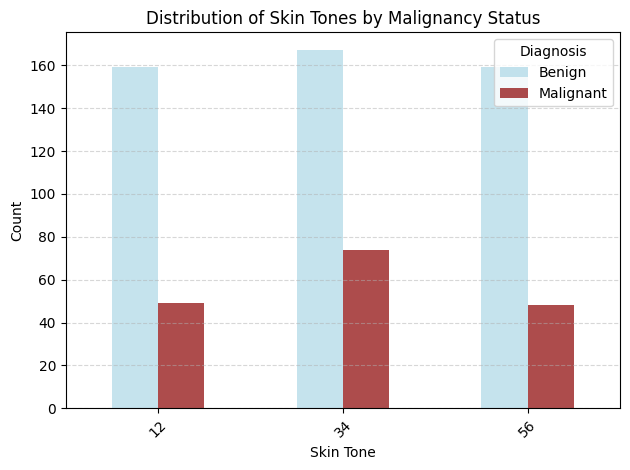

Percentage of malignant cases within each skin tone:
Skin tone 12: 23.56% malignant (49 out of 208)
Skin tone 34: 30.71% malignant (74 out of 241)
Skin tone 56: 23.19% malignant (48 out of 207)


In [4]:
# Check if 'skin_tone' column exists in the metadata
if 'skin_tone' in metadata.columns:
  # Create a grouped bar chart by skin tone and malignancy
  plt.figure(figsize=(12, 7))
  
  # Group by skin tone and malignant status and count occurrences
  grouped_data = metadata.groupby(['skin_tone', 'malignant']).size().unstack()
  
  # Rename columns for better clarity in the legend
  grouped_data.columns = ['Benign', 'Malignant']
  
  # Create the grouped bar chart
  grouped_data.plot(kind='bar', color=['lightblue', 'darkred'], alpha=0.7)
  
  plt.title('Distribution of Skin Tones by Malignancy Status')
  plt.xlabel('Skin Tone')
  plt.ylabel('Count')
  plt.xticks(rotation=45)
  plt.grid(axis='y', linestyle='--', alpha=0.5)
  plt.legend(title='Diagnosis')
  plt.tight_layout()
  plt.show()
  
  # Print percentage distribution by skin tone and malignancy
  print("Percentage of malignant cases within each skin tone:")
  for tone in grouped_data.index:
    malignant_count = grouped_data.loc[tone, 'Malignant'] if 'Malignant' in grouped_data.columns else 0
    total = grouped_data.loc[tone].sum()
    pct = (malignant_count / total) * 100
    print(f"Skin tone {tone}: {pct:.2f}% malignant ({malignant_count} out of {total})")
else:
  print("No 'skin_tone' column found in the metadata.")

## Label Distribution

Visualise the distribution of malignant and benign cases in our dataset, which is critical for understanding class imbalance. The histogram below shows the frequency of each class (malignant vs. benign) in our dataset. This information will help us determine appropriate strategies for handling imbalance during model training, such as resampling techniques or class weighting.

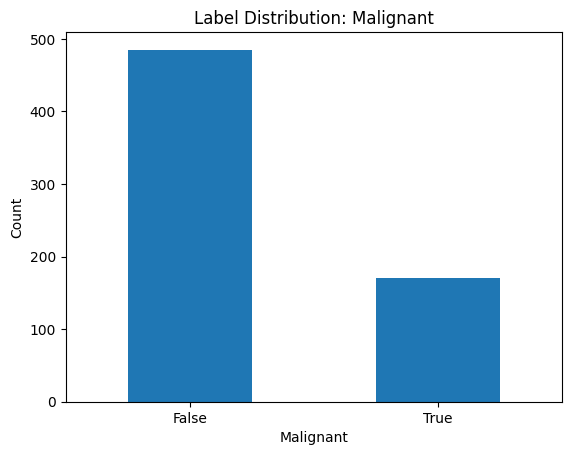

In [5]:
# Plot bar chart for label distribution
metadata['malignant'].value_counts().plot(kind='bar', rot=0)
plt.xlabel('Malignant')
plt.ylabel('Count')
plt.title('Label Distribution: Malignant')
plt.show()

## Data Imbalance Analysis

The histogram above reveals a significant class imbalance in our dataset, with benign cases (label 'False') outnumbering malignant cases (label 'True'). This imbalance presents several challenges for model training:

1. **Classification bias**: Models may develop a bias toward the majority class (benign), potentially misclassifying malignant samples
2. **Performance metrics**: Accuracy alone would be misleading in this context, as a naive classifier predicting all samples as benign would still achieve high accuracy
3. **Clinical implications**: In medical diagnostics, false negatives (missing actual malignant cases) can have serious consequences

We'll need to address this imbalance through techniques such as:
- Resampling methods (undersampling or oversampling)
- Class weighting in the loss function
- Specialised evaluation metrics (F1-score, precision-recall AUC)

## Label Conversion

Converting categorical labels to numeric format is an essential preprocessing step for machine learning models. In our case, we're converting the 'malignant' boolean feature (True/False) to binary integers (1/0), where:
- 1 represents malignant cases (positive class)
- 0 represents benign cases (negative class)

In [6]:
# Convert 'malignant' column to integer type
metadata['malignant'] = metadata['malignant'].astype(int)
metadata.tail()

,Unnamed: 0,DDI_ID,DDI_file,skin_tone,malignant,disease
651,651,652,000652.png,34,0,pyogenic-granuloma
652,652,653,000653.png,34,0,melanocytic-nevi
653,653,654,000654.png,34,0,acral-melanotic-macule
654,654,655,000655.png,34,1,squamous-cell-carcinoma
655,655,656,000656.png,34,1,basal-cell-carcinoma


## Combine Skin Tone and Label (Malignant) for Stratification

In [7]:
# Create new column for strata combining skin tone and malignancy
metadata['strata'] = metadata['skin_tone'].astype(str) + '_' + metadata['malignant'].astype(str)
# Rename the DDI_file column to image_id for better clarity
metadata.rename(columns={'DDI_file': 'image_id'}, inplace=True)

metadata.head()

,Unnamed: 0,DDI_ID,image_id,skin_tone,malignant,disease,strata
0,0,1,000001.png,56,1,melanoma-in-situ,56_1
1,1,2,000002.png,56,1,melanoma-in-situ,56_1
2,2,3,000003.png,56,1,mycosis-fungoides,56_1
3,3,4,000004.png,56,1,squamous-cell-carcinoma-in-situ,56_1
4,4,5,000005.png,12,1,basal-cell-carcinoma,12_1


## Store Metadata

The updated CSV will be stored in the data directory, ensuring consistency across our workflow. This version of the metadata will be used for model training, evaluation, and any further analysis.

In [8]:
# Check if the directory exists, if not create it
if not os.path.exists(data_path):
    os.makedirs(data_path)

# Store the update metadata in new CSV file
new_metadata_path = data_path / 'metadata_updated.csv'
metadata.to_csv(new_metadata_path, index=False)

## HAM Dataset

In [9]:
data_dir = Path.cwd().parent / 'data' / 'raw_dataset'
ham_df = pd.read_csv(data_dir / 'HAM10000' / 'metadata.csv')
ham_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [10]:
# Define the path to HAM10000 images directory
ham_images_path = data_dir / 'HAM10000' / 'images'

# List all image files in the directory
ham_image_files = os.listdir(ham_images_path) if ham_images_path.exists() else []

# Extract image ids from the filenames (removing file extensions)
image_ids_present = [os.path.splitext(file)[0] for file in ham_image_files]

# Filter the dataframe to include only rows where image_id is present in the directory
ham_df_filtered = ham_df[ham_df['image_id'].isin(image_ids_present)]

# Print the result
print(f"Original DataFrame size: {ham_df.shape[0]} rows")
print(f"Filtered DataFrame size: {ham_df_filtered.shape[0]} rows")
print(f"Number of missing images: {ham_df.shape[0] - ham_df_filtered.shape[0]}")

# Preview the filtered dataframe
ham_df_filtered.head()

Original DataFrame size: 10015 rows
Filtered DataFrame size: 5015 rows
Number of missing images: 5000


,lesion_id,image_id,dx,dx_type,age,sex,localization
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
11,HAM_0004234,ISIC_0029396,bkl,histo,85.0,female,chest
14,HAM_0001949,ISIC_0032417,bkl,histo,70.0,male,trunk
15,HAM_0007207,ISIC_0031326,bkl,histo,65.0,male,back
17,HAM_0001601,ISIC_0031029,bkl,histo,75.0,male,upper extremity


In [11]:
ham_df_2 = ham_df_filtered[ham_df_filtered['dx'] != 'nv']
ham_df_2['dx'].shape

(1741,)

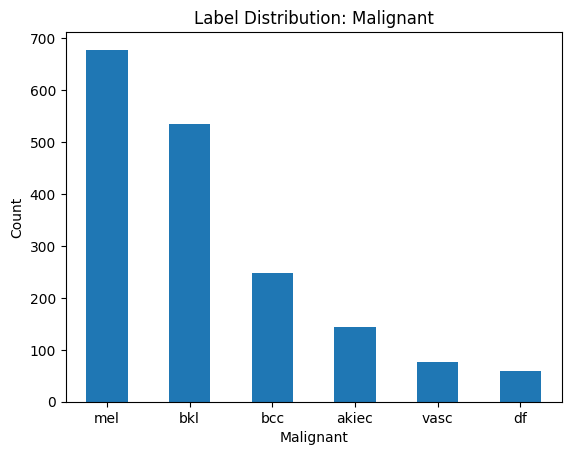

In [12]:
# Plot bar chart for label distribution
ham_df_2['dx'].value_counts().plot(kind='bar', rot=0)
plt.xlabel('Malignant')
plt.ylabel('Count')
plt.title('Label Distribution: Malignant')
plt.show()

In [13]:
malignant = ['bcc', 'akiec', 'mel']
ham_df_2['dx'] = ham_df_2['dx'].apply(lambda x: 1 if x in malignant else 0)
ham_df_2.rename(columns={'dx': 'malignant'}, inplace=True)
ham_df_2.head()

C:\Users\dango\AppData\Local\Temp\ipykernel_2804\1392780303.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ham_df_2['dx'] = ham_df_2['dx'].apply(lambda x: 1 if x in malignant else 0)
C:\Users\dango\AppData\Local\Temp\ipykernel_2804\1392780303.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ham_df_2.rename(columns={'dx': 'malignant'}, inplace=True)


,lesion_id,image_id,malignant,dx_type,age,sex,localization
4,HAM_0001466,ISIC_0031633,0,histo,75.0,male,ear
11,HAM_0004234,ISIC_0029396,0,histo,85.0,female,chest
14,HAM_0001949,ISIC_0032417,0,histo,70.0,male,trunk
15,HAM_0007207,ISIC_0031326,0,histo,65.0,male,back
17,HAM_0001601,ISIC_0031029,0,histo,75.0,male,upper extremity


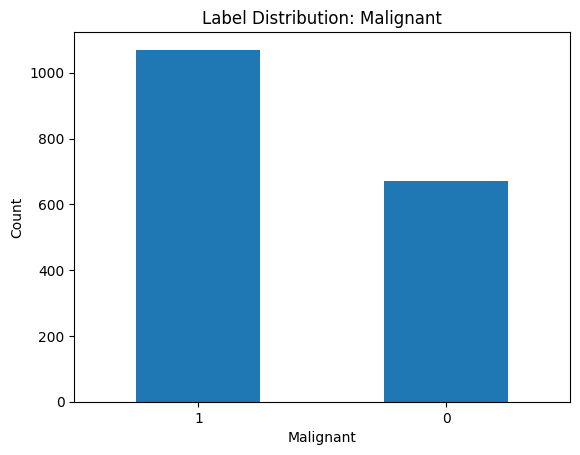

In [14]:
# Plot bar chart for label distribution
ham_df_2['malignant'].value_counts().plot(kind='bar', rot=0)
plt.xlabel('Malignant')
plt.ylabel('Count')
plt.title('Label Distribution: Malignant')
plt.show()

In [15]:
# Store the update HAM metadata in new CSV file
ham_metadata_path = data_path / 'ham_metadata_updated.csv'
ham_df_2.to_csv(ham_metadata_path, index=False)